#dependencies

In [1]:
import tensorflow as tf 

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [4]:
print(tf.__version__)

2.5.0


#import data

In [5]:
import pandas as pd
file = 'D:/data/train.csv'   
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [6]:
df = pd.read_csv('D:/data/train.csv',encoding='ascii')
GCS_DS_PATH = 'D:/data/train_images/'
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [8]:
a=df.copy()
a=pd.get_dummies(a['labels'])
df1=pd.concat([df, a], axis=1)
df1.head()

,image,labels,complex,frog_eye_leaf_spot,frog_eye_leaf_spot complex,healthy,powdery_mildew,powdery_mildew complex,rust,rust complex,rust frog_eye_leaf_spot,scab,scab frog_eye_leaf_spot,scab frog_eye_leaf_spot complex
0,800113bb65efe69e.jpg,healthy,0,0,0,1,0,0,0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,0,0,0,0,0,0,0,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,0,0,0,0,0,0,0,0,1,0,0
3,80077517781fb94f.jpg,scab,0,0,0,0,0,0,0,0,0,1,0,0
4,800cbf0ff87721f8.jpg,complex,1,0,0,0,0,0,0,0,0,0,0,0


image                              800113bb65efe69e.jpg8002cb321f8bfcdf.jpg80070f...
labels                             healthyscab frog_eye_leaf_spot complexscabscab...
complex                                                                         1602
frog_eye_leaf_spot                                                              3181
frog_eye_leaf_spot complex                                                       165
healthy                                                                         4624
powdery_mildew                                                                  1184
powdery_mildew complex                                                            87
rust                                                                            1860
rust complex                                                                      97
rust frog_eye_leaf_spot                                                          120
scab                                                             

<ipython-input-9-7943e42dc702>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts = df1.mean()


<AxesSubplot:>

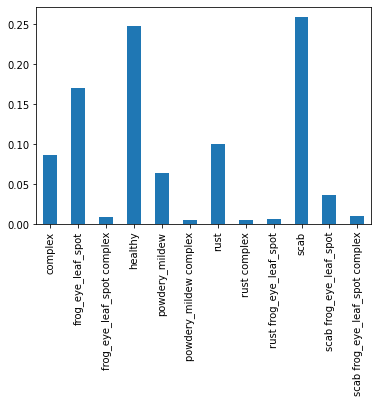

In [9]:
print(df1.sum())
pcts = df1.mean()
pcts.plot(kind = 'bar')

<AxesSubplot:ylabel='None'>

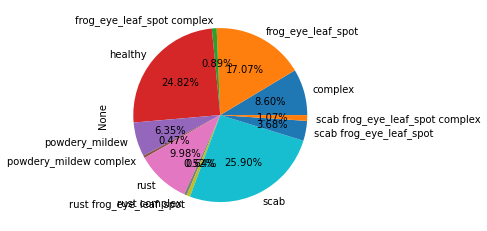

In [10]:
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [11]:
df[df.labels=='powdery_mildew complex']='powdery_mildew'

In [12]:
df[df.labels=='rust frog_eye_leaf_spot']='rust'

In [13]:
df[df.labels=='rust complex']='rust'

In [14]:
df[df.labels=='frog_eye_leaf_spot complex']='frog_eye_leaf_spot'

In [15]:
df[df.labels=='scab frog_eye_leaf_spot']='scab'

In [16]:
df[df.labels=='scab frog_eye_leaf_spot complex']='scab'

In [17]:
a=df.copy()
a=pd.get_dummies(a['labels'])
data=pd.concat([df, a], axis=1)
data.head()

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,0,0,1,0,0,0
1,scab,scab,0,0,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,1,0,0,0,0,0


In [18]:
data.drop(columns='labels',inplace=True)

image                 800113bb65efe69e.jpgscab80070f7fb5e2ccaa.jpg80...
complex                                                            1602
frog_eye_leaf_spot                                                 3346
healthy                                                            4624
powdery_mildew                                                     1271
rust                                                               2077
scab                                                               5712
dtype: object


<ipython-input-19-089b829e98a5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts = data.mean()


<AxesSubplot:>

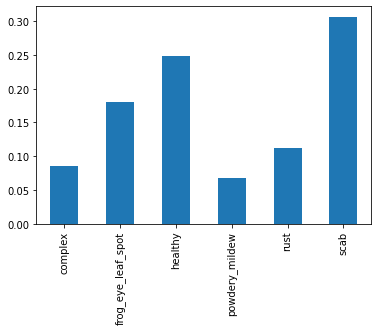

In [19]:
print(data.sum())
pcts = data.mean()
pcts.plot(kind = 'bar')

<AxesSubplot:ylabel='None'>

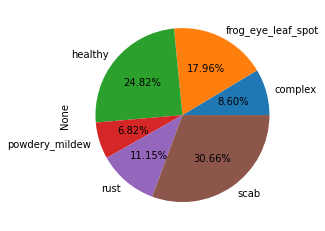

In [20]:
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [21]:
data.shape

(18632, 7)

In [22]:
IMG_SIZE = 1210

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 2048
seed_everything(seed)
print("REPLICAS: ", 8)



#paths

data_paths = data.image.apply(lambda x: GCS_DS_PATH+ x ).values


#labels

data_labels = data.loc[:,['complex','frog_eye_leaf_spot','powdery_mildew','healthy','scab','rust']].values

#split train data to train and valisation data 
train_paths, test_paths, train_labels, test_labels =train_test_split(data_paths, data_labels, test_size=0.2, random_state=seed)

SPLIT_VALIDATION =True
if SPLIT_VALIDATION:
    train_paths, valid_paths, train_labels, valid_labels =train_test_split(train_paths, train_labels, test_size=0.2, random_state=seed)
print(len(train_paths))
print(len(test_paths))
print(len(valid_paths))

def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

REPLICAS:  8
11924
3727
2981


In [23]:
data_labels[0]

array([0, 0, 0, 1, 0, 0], dtype=uint8)

In [24]:
data_paths[0]

'D:/data/train_images/800113bb65efe69e.jpg'

#building the dataset(train, test, validation) 

In [25]:
BATCH_SIZE = 8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

train_dataset_1 = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths, test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)



#hyperparametres

In [26]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

#data visualisation 

(2672, 4000, 3)


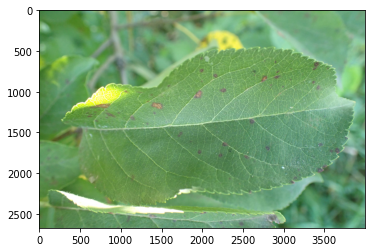

In [27]:
from matplotlib import pyplot as plt

img = plt.imread(data_paths[100])
print(img.shape)
plt.imshow(img)

image                 800113bb65efe69e.jpgscab80070f7fb5e2ccaa.jpg80...
complex                                                            1602
frog_eye_leaf_spot                                                 3346
healthy                                                            4624
powdery_mildew                                                     1271
rust                                                               2077
scab                                                               5712
dtype: object


<ipython-input-28-089b829e98a5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts = data.mean()


<AxesSubplot:>

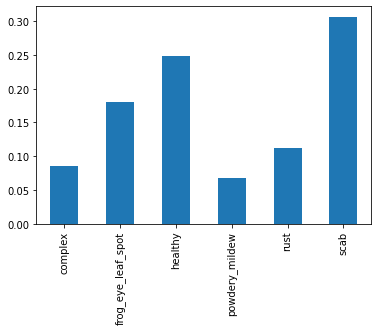

In [28]:
print(data.sum())
pcts = data.mean()
pcts.plot(kind = 'bar')

<AxesSubplot:ylabel='None'>

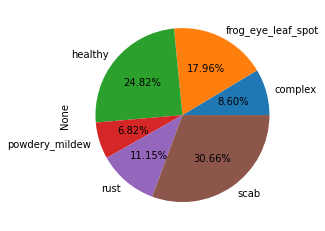

In [29]:
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [30]:
import h5py
h5py.__version__

'3.1.0'

#building our model

In [31]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras
Dense_net = keras.models.load_model('xceptions')

In [32]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras
IMG_SIZE=1210
import tensorflow as tf 
from tensorflow.keras import datasets, layers, models

In [33]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(1210, 1210, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(3, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(3, (3, 3), activation='relu'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1208, 1208, 3)     84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 604, 604, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 602, 602, 3)       84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 301, 301, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 3)       84        
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________


In [35]:
base_model = tf.keras.applications.Xception(input_shape=(299,299,3),
                                                include_top=False,
                                                weights='imagenet')

In [36]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [37]:
mod=model.output

In [38]:
mod

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'conv2d_2')>

In [39]:
x = base_model(mod)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)

In [41]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [49]:
mergedOut = tf.keras.layers.Add()([model.output,base_model.input])

In [ ]:
zakaria.haja@ueuromed.org

In [53]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
models =  keras.Model(inputs = base_model.input,outputs=x)

In [ ]:
models=Model(inputs=[model.input, base_model.input], outputs=out)
models.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras
IMG_SIZE=299
base_model = tf.keras.applications.Xception(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=True,
                                               weights='imagenet')
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model =  keras.Model(inputs = base_model.input,outputs=x)

model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])


In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 1208, 1208, 3)     84        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 604, 604, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 602, 602, 3)       84        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 301, 301, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 299, 299, 3)       84        
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________


In [34]:
Dense_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:

history=models.fit(
    train_dataset,
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    epochs=40,
    validation_data=valid_dataset)

#show the loss and the accuracy 

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=8)
print("test loss, test acc:", results)


In [59]:
import pickle
with open('training_log/xceptionmodel.pkl', 'wb') as output:
        pickle.dump(history.history, output)

In [60]:
model.save('xception/xception.h5')

C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [61]:
model.save('xceptions')

C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: xceptions\assets
